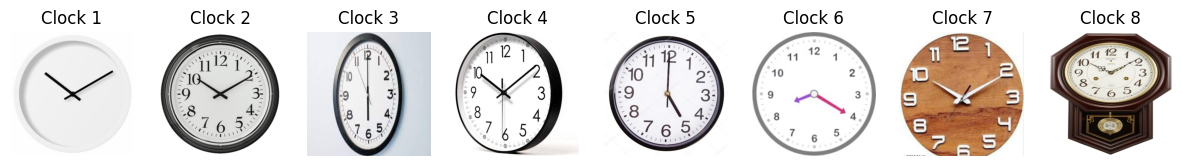

In [9]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Funzione per caricare le immagini
def load_images():
    images = []
    for img_path in sorted(os.listdir("./images")):
        if "clock" in img_path and img_path.endswith(".jpg"):
            img = cv2.imread("./images/" + img_path)
            if img is not None:
                # Ridimensiona l'immagine a 640x640
                img = cv2.resize(img, (640, 640))
                images.append(img)
            else:
                print(f"Immagine non trovata: {img_path}")
    return images

# Funzione per mostrare le immagini
def show_images(images):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)  # Mostra tutte le immagini in una riga
        plt.title(f"Clock {i+1}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Converte BGR a RGB
        plt.axis('off')  # Nasconde gli assi
    plt.show()

# Carica le immagini
images = load_images()

# Mostra le immagini caricate
show_images(images)

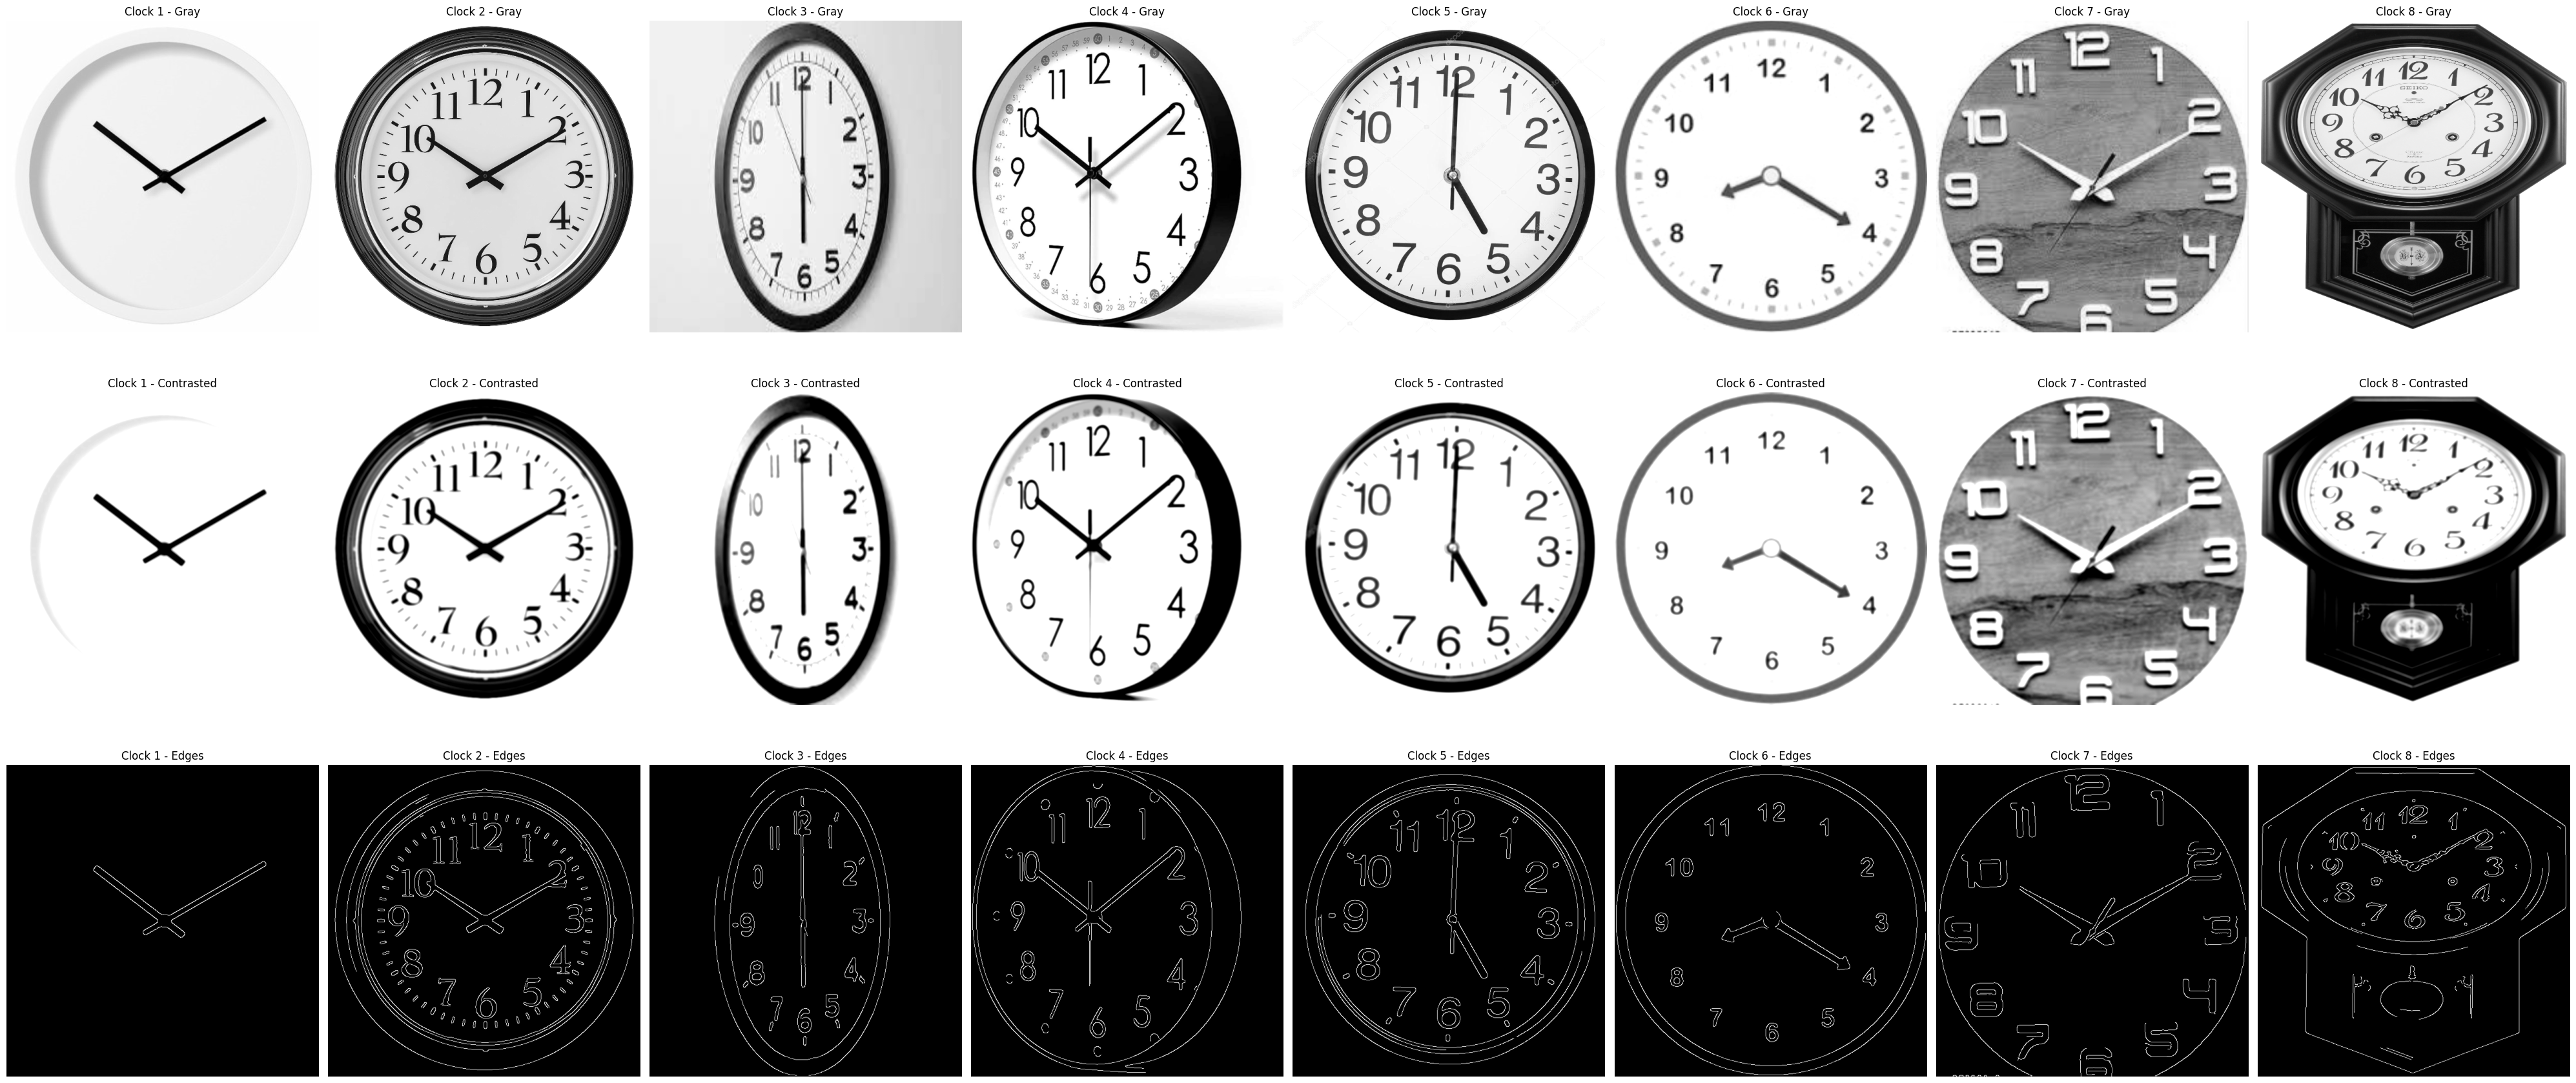

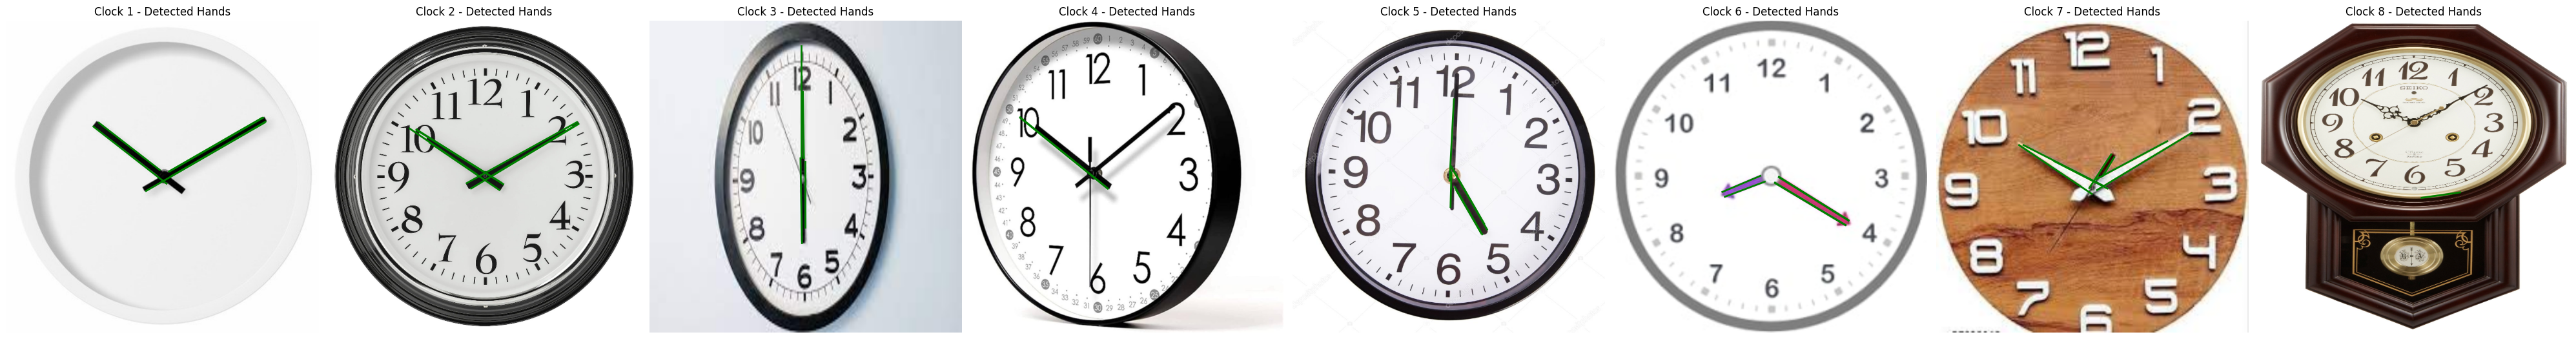

In [27]:
def contrast(image, factor, brightness=0):
    image = np.int16(image)
    image = image * (factor / 127 + 1) - factor + brightness
    image = np.clip(image, 0, 255)
    image = np.uint8(image)

    return image

def detect_clock_hands(images):
    hands_list = []
    num_images = len(images)

    plt.figure(figsize=(5 * num_images, 18))  # Imposta la dimensione del plot

    for i, img in enumerate(images):
        # Converte l'immagine in scala di grigi
        gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

        plt.subplot(3, num_images, i + 1)  # Posizione del subplot per immagine in scala di grigi
        plt.imshow(gray, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Gray")

        # Applica un filtro Gaussian per ridurre il rumore
        blurred = cv2.GaussianBlur(gray, (9, 9), 2)

        contrasted = contrast(blurred, 100)

        plt.subplot(3, num_images, num_images + i + 1)  # Posizione del subplot per immagine dei bordi
        plt.imshow(contrasted, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Contrasted")


        # Applica il Canny Edge Detector
        edges = cv2.Canny(contrasted, 
                          threshold1=200, 
                          threshold2=300
                )

        plt.subplot(3, num_images, num_images*2 + i + 1)  # Posizione del subplot per immagine dei bordi
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Edges")

        # Rileva le linee usando HoughLinesP
        lines = cv2.HoughLinesP(
            edges,
            rho=1,
            theta=np.pi / 180,
            threshold=50,
            minLineLength=30,
            maxLineGap=20
        )

        # Trova il centro dell'orologio
        height, width = edges.shape
        center = (width // 2, height // 2)
        center_threshold = 50  # Distanza massima dell'endpoint dal centro
        
        # Filtra le linee basate sulla distanza dal centro
        filtered_lines = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]

                # Calcola le distanze degli endpoint dal centro
                dist1 = np.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2)
                dist2 = np.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2)
                
                # Conserva la linea se un endpoint è vicino al centro e l'altro è più lontano
                if (dist1 < center_threshold and dist2 >= center_threshold) or (dist2 < center_threshold and dist1 >= center_threshold):
                    filtered_lines.append(line[0])

        hands_list.append(filtered_lines)

    plt.tight_layout()  # Migliora la disposizione dei subplot
    plt.show()  # Mostra tutti i subplot in una volta
    return hands_list

# Funzione per mostrare le lancette rilevate
def show_hands(images, hands_list):
    num_images = len(images)
    plt.figure(figsize=(5 * num_images, 8))  # Imposta la dimensione del plot

    for i, (img, lines) in enumerate(zip(images, hands_list)):
        plt.subplot(1, num_images, i + 1)  # Posizione del subplot
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Clock {i + 1} - Detected Hands")

        # Disegna le linee rilevate sull'immagine
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line
                plt.plot([x1, x2], [y1, y2], color='green', linewidth=2)

    plt.tight_layout()  # Migliora la disposizione dei subplot
    plt.show()  # Mostra tutti i subplot in una volta

# Rileva le lancette degli orologi
hands_list = detect_clock_hands(images)

# Mostra le lancette rilevate
show_hands(images, hands_list)

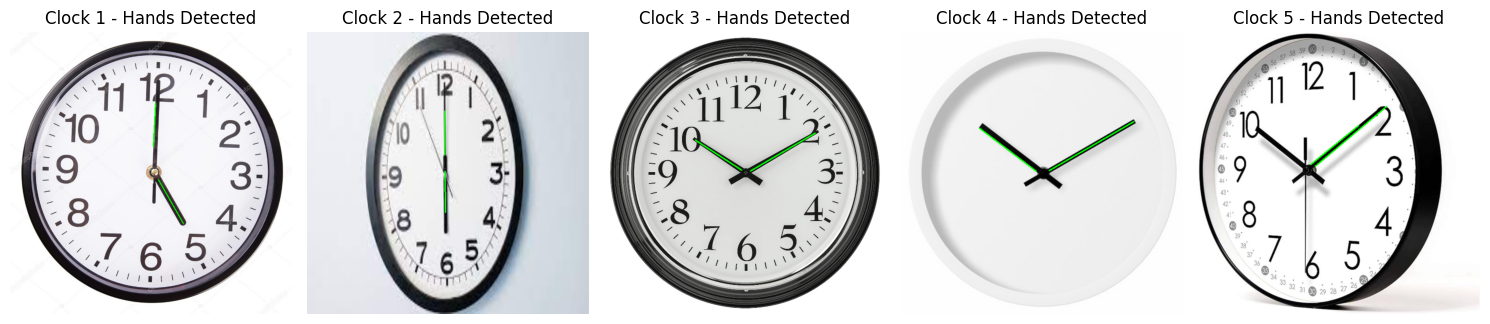

In [57]:
import math

def calculate_angle(x1, y1, x2, y2):
    """
    Calcola l'angolo di una linea rispetto alla verticale.
    """
    dx = x2 - x1
    dy = y2 - y1
    angle = math.degrees(math.atan2(dy, dx))
    if angle < 0:
        angle += 360
    return angle

def group_lines(lines, angle_threshold=10, length_threshold=20):
    """
    Group detected lines by angle and length, then identify and merge lines 
    that likely belong to the same clock hand.
    """
    # Prepare arrays to store groups based on angle and length similarity
    grouped_lines = []
    
    # Loop through each line and calculate angle and length
    for i, line in enumerate(lines):
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        angle = calculate_angle(x1, y1, x2, y2)

        # Attempt to find a group for this line
        found_group = False
        for group in grouped_lines:
            # Check if the angle and length match this group's characteristics
            if abs(group['angle'] - angle) < angle_threshold and abs(group['length'] - length) < length_threshold:
                group['lines'].append(line[0])
                found_group = True
                break
        
        # If no matching group was found, create a new one
        if not found_group:
            grouped_lines.append({'angle': angle, 'length': length, 'lines': [line[0]]})
    
    # Merge lines within each group to form one line for each hand
    hands = []
    for group in grouped_lines:
        # Calculate the average position for this group
        avg_x1 = int(np.mean([l[0] for l in group['lines']]))
        avg_y1 = int(np.mean([l[1] for l in group['lines']]))
        avg_x2 = int(np.mean([l[2] for l in group['lines']]))
        avg_y2 = int(np.mean([l[3] for l in group['lines']]))
        
        # Add to hands list as a single, representative line for this group
        hands.append([avg_x1, avg_y1, avg_x2, avg_y2])
    
    # Identify minute and hour hands based on length
    if len(hands) >= 2:
        hands = sorted(hands, key=lambda l: np.sqrt((l[2] - l[0]) ** 2 + (l[3] - l[1]) ** 2), reverse=True)
        minute_hand = hands[0]
        hour_hand = hands[1]
        return minute_hand, hour_hand
    elif len(hands) == 1:
        # In case only one hand is detected, assume it's the minute hand
        return hands[0], None
    else:
        return None, None

def plot_grouped_lines(images, hands_list):
    """
    Plotta le linee raggruppate (lancette) su ogni immagine originale.
    """
    plt.figure(figsize=(15, 5))

    grouped_hands_list = []
    
    for i, (img, hands) in enumerate(zip(images, hands_list)):

        if hands is None:
            print("No hands detected for clock", i + 1)
            continue
        
        # Ottieni le linee raggruppate
        grouped_lines = group_lines(hands)
        
        # Crea una copia dell'immagine per disegnare sopra
        img_with_hands = img.copy()
        
        # Disegna le linee raggruppate (lancette) sull'immagine
        for line in grouped_lines:
            x1, y1, x2, y2 = line
            cv2.line(img_with_hands, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Visualizza l'immagine con le lancette in un subplot
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv2.cvtColor(img_with_hands, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title(f"Clock {i + 1} - Hands Detected")

        grouped_hands_list.append(grouped_lines)

    plt.tight_layout()
    plt.show()

    return grouped_hands_list

center_x, center_y = 320, 320  # Supponiamo un'immagine 640x640
hands = plot_grouped_lines(images, hands_list)

In [58]:
def determine_time(hands_list):
    """
    Determine the approximate time on each clock based on the angles of two hands.
    """
    times = []
    
    for hands in hands_list:
        if len(hands) < 2:
            times.append("Not enough hands detected")
            continue
        
        # Calculate angles for the two hands
        angle1 = calculate_angle(*hands[0])
        angle2 = calculate_angle(*hands[1])
        
        # Identify the minute and hour hands based on angles
        # Assume the longer hand is the minute hand, which should have a smaller angle incrementally
        if abs(angle1 - angle2) <= 180:
            minute_angle, hour_angle = (angle1, angle2) if angle1 > angle2 else (angle2, angle1)
        else:
            minute_angle, hour_angle = (angle1, angle2) if angle1 < angle2 else (angle2, angle1)

        # Calculate minutes and hours from the angles
        minutes = int(((-minute_angle + 90) % 360) / 6)
        hours = int((hour_angle % 360) / 30)
        
        # Adjust hour for 12-hour format
        hours = hours if hours != 0 else 12
        
        # Append the time in HH:MM format
        times.append(f"{hours:02}:{minutes:02}")
    
    return times
# Determine the time for each clock
clock_times = determine_time(hands)
print(clock_times)  # Output the determined times

['09:04', '09:00', '10:09', '10:08', '10:21']
